In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import load_iris

In [6]:
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

In [7]:
df = pd.DataFrame(X, columns=feature_names)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [9]:
# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# 2D PCA for visualization only
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

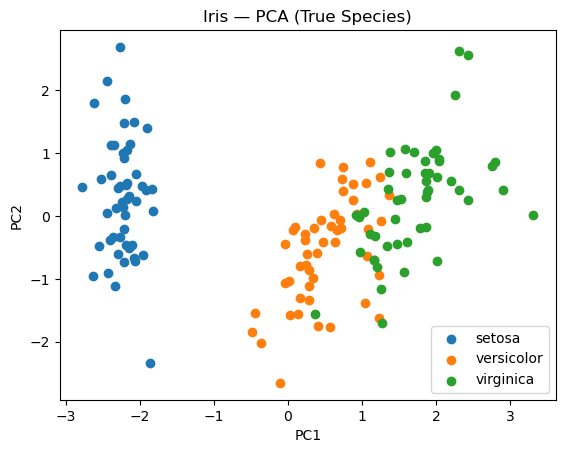

In [11]:
# Plot PCA with true labels (for reference only; not used by clustering)
plt.figure()
for i in range(len(target_names)):
    idx = y == i
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=target_names[i])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Iris — PCA (True Species)")
plt.legend()
plt.show()

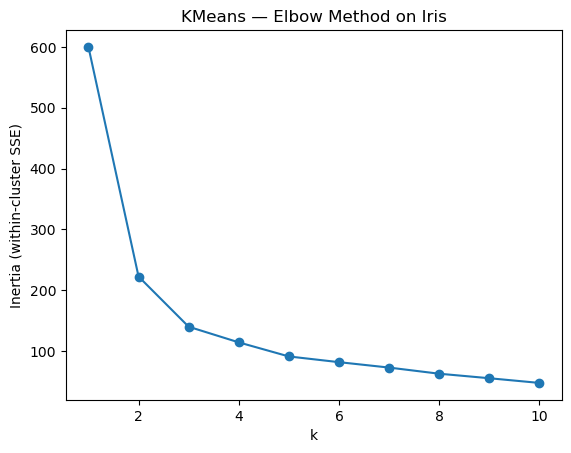

In [13]:
# Choose K for KMeans (Elbow and Silhouette)
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
Ks = list(range(1, 11))
inertias = []
for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(Ks, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("KMeans — Elbow Method on Iris")
plt.show()

**Comment:** Here Elbow plot (“Inertia vs k”) drops quickly and then flattens; the visible bend is around k ≈ 3 (sometimes {2,3} both look plausible). Picking k=3 aligns with the biology (three species) and the plot. 

In [15]:
# Fit final KMeans with k=3 (known classes = 3)
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, n_init=10, random_state=42)
km_labels = kmeans.fit_predict(X_scaled)

In [16]:
# Evaluation against true labels
km_ari = adjusted_rand_score(y, km_labels)
km_ami = adjusted_mutual_info_score(y, km_labels)

print(f"KMeans (k={k_opt}) — Adjusted Rand Index: {km_ari:.4f}")
print(f"KMeans (k={k_opt}) — Adjusted Mutual Information: {km_ami:.4f}")

KMeans (k=3) — Adjusted Rand Index: 0.6201
KMeans (k=3) — Adjusted Mutual Information: 0.6552


**Comment:** Metrics printed:
ARI = 0.6201, AMI = 0.6552 → moderate agreement with true species (1.0 would be perfect)

In [18]:
# Helper for displaying tables nicely in the UI
try:
    from ace_tools import display_dataframe_to_user
except Exception:
    display_dataframe_to_user = None
# Contingency table
km_ct = pd.crosstab(pd.Series(km_labels, name="Cluster"), pd.Series([target_names[i] for i in y], name="Species"))
if display_dataframe_to_user:
    display_dataframe_to_user("KMeans — Cluster vs Species", km_ct)
else:
    print(km_ct)

Species  setosa  versicolor  virginica
Cluster                               
0             0          39         14
1            50           0          0
2             0          11         36


Cluster 0: setosa 0,  versicolor 39, virginica 14 <br>
Cluster 1: setosa 50, versicolor 0,  virginica 0 <br>
Cluster 2: setosa 0,  versicolor 11, virginica 36

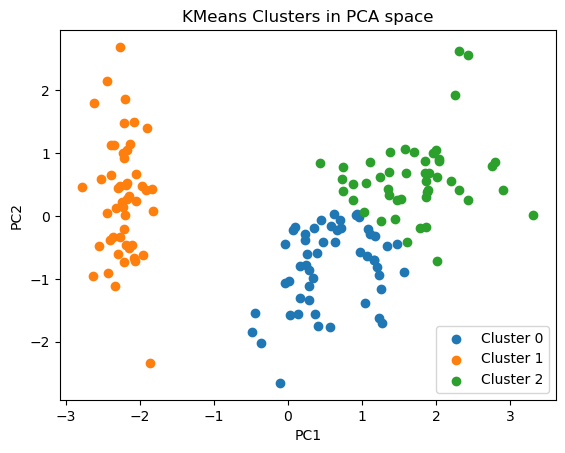

In [19]:
# Visualize KMeans clusters in PCA space
plt.figure()
for c in np.unique(km_labels):
    idx = km_labels == c
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f"Cluster {c}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clusters in PCA space")
plt.legend()
plt.show()

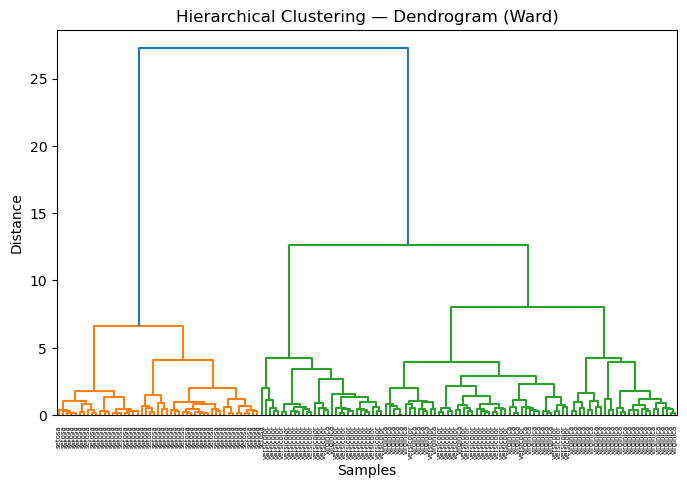

In [26]:
# Hierarchical (Agglomerative) Clustering
# Linkage/Dendrogram (Ward's method on scaled data)
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.neighbors import NearestNeighbors

Z = linkage(X_scaled, method="ward")
plt.figure(figsize=(8, 5))
dendrogram(Z, labels=[target_names[i] for i in y], leaf_rotation=90)
plt.title("Hierarchical Clustering — Dendrogram (Ward)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

In [22]:
# Cut into 3 clusters using AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=3, linkage="ward")
agg_labels = agg.fit_predict(X_scaled)

agg_ari = adjusted_rand_score(y, agg_labels)
agg_ami = adjusted_mutual_info_score(y, agg_labels)

print(f"Agglomerative (Ward, k=3) — Adjusted Rand Index: {agg_ari:.4f}")
print(f"Agglomerative (Ward, k=3) — Adjusted Mutual Information: {agg_ami:.4f}")

agg_ct = pd.crosstab(pd.Series(agg_labels, name="Cluster"), pd.Series([target_names[i] for i in y], name="Species"))
if display_dataframe_to_user:
    display_dataframe_to_user("Agglomerative — Cluster vs Species", agg_ct)
else:
    print(agg_ct)

Agglomerative (Ward, k=3) — Adjusted Rand Index: 0.6153
Agglomerative (Ward, k=3) — Adjusted Mutual Information: 0.6713
Species  setosa  versicolor  virginica
Cluster                               
0             0          23         48
1            49           0          0
2             1          27          2


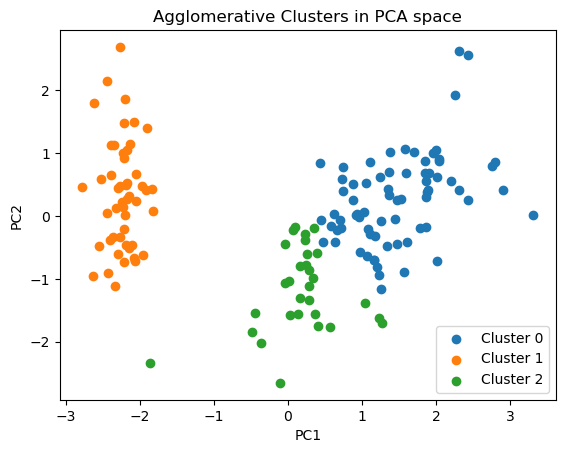

In [23]:
# Visualize Agglomerative clusters in PCA space
plt.figure()
for c in np.unique(agg_labels):
    idx = agg_labels == c
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f"Cluster {c}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Agglomerative Clusters in PCA space")
plt.legend()
plt.show()
